# Análisis de imágenes de Sargazo

---
+ **Angeles Reyes Francisco Javier**  *#417011361*
+ **Bustamante Piza Karla Mireli** *#314135308*
+ **Sala Mora Mónica** *#314061481*

### Librerías

In [1]:
# Librería de OpenCV
import cv2
# Librería Numpy para Arrays y operaciones matriciales
import numpy as np
# Libreria para las gráficas
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Mapa de colores
from PIL import Image #Procesamiento de imagenes

from skimage.color import label2rgb #Colorear las etiquetas en una imagen segmentada

#Filtros
from skimage.filters import sobel,unsharp_mask

# Libreria del KKN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Librería para crear barras de progreso
from tqdm.notebook import tqdm as tqdm

#Monitorear tiempos de ejecucion
import time

#Libreria para importar direcotrios
from os import listdir

### Funciones para cargar y mostrar imagenes

In [2]:
#Funcion que recibebe la direccion de la carpeta con las imagenes muestra, con un nombre base seguido de un arreglo de numeros y el tipo de archivo (debe ser la misma)
def ReadImg(folderPath,baseName,samples,fileExtension):
    images = list() #Se crea una lista vacia para contener las imagenes
    for i in samples: #Para cada imagen enumerada desde el 1
        filePath=folderPath + baseName + str(i) + fileExtension #Se crea un string para almacenar la direccion de cada imagen
        try:
            images.append(Image.open(filePath).convert("HSV")) #Se intenta agregar la imagen en formato HSV
        except:
            print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso
            
    return images #Se regresa una lista de imagenes

In [3]:
#Mostrar varias imagenes en una sola figura
def showNImg(imgList):
    fig, plots = plt.subplots(1,len(imgList)) #Se crean las graficas en una lista de subplots

    for i in range(0,len(imgList)):
        plots[i].imshow(imgList[i]) #Se muestra cada imagen de entrenamiento

In [4]:
#Funcion para obtener las imagenes de entrenamiento con la mascara de recorte a partir del canal alpha.
def ReadAlpha(folderPath,baseName,samples,fileExtension):
    #images = list() #Se crea una lista vacia para contener las imagenes
    alphas = list() #Se crea una lista vacia para contener los canales alpha
    for i in range(1,samples+1): #Para cada imagen enumerada desde el 1
        filePath=folderPath + baseName + str(i) + fileExtension #Se crea un string para almacenar la direccion de cada imagen
        try:
            img = Image.open(filePath) #Se guarda la imagen en una variable
            #images.append(np.array(img.convert("HSV")))
            alpha = np.asarray(img.split()[-1]) #Se extrae el canal alpha
            alphas.append(alpha) #Se agrega la mascara a la lista
        except:
            print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso
            
    return alphas #Se regresa una lista de imagenes

## Pruebas con la iluminación

Se tomaron tres imágenes de prueba con distinta iluminación y tamaño del cuerpo de sargazo, para poder determinar de manera empírica qué filtros podrían facilitar la detección.

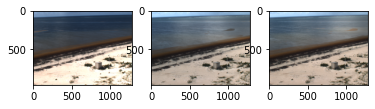

In [5]:
imges = ReadImg('Test/','Test',[1,2,3],'.png')
showNImg(imges)
plt.savefig('Figures/Pruebas_Iluminacion.png')

Se tomó una de las imágenes de prueba para comprobar en qué canal HSV se puede observar mejor el sargazo y adicionalmente se le aplicó un filtro (Unsharp Masking) para realzar los bordes. El canal HUE parece separar mejor las regiones grandes con sargazo, mientras que el canal Saturation marca mejor los bordes de las olas para diferenciarlo en texturas del sargazo. En el canal Value no se aprecian muy bien las manchas de sargazo, pues tiene que ver más con la incidencia de la luz sobre los cuerpos.

<Figure size 432x288 with 0 Axes>

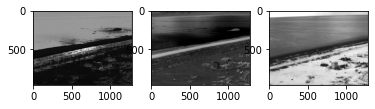

In [6]:
#Se toma una imagen cualquiera
testImg = np.array(imges[2])
#Se le aplica Unsharp Masking a la imagen de prueba. Con multichanel en True se especifica que es una imagen de distintos canales, de otra forma aplica el filtro para cada canal
testImg = unsharp_mask(testImg,radius=3,amount=0.1,multichannel=False)

#Se muestra la imagen en escala de grises
plt.gray()
#Se muestra la imagen en sus tres canales por separado; Hue, Saturation, Value, respectivamente.
showNImg([testImg[:,:,0],testImg[:,:,1],testImg[:,:,2]])
#Guardar figura
plt.savefig('Figures/UM_HSVTest.png')

## Prueba de segmentación en el canal "Saturation" con un filtro Sobel

Ya que el canal Saturation parece ser en el que mejor se resaltan los bordes, se utilizó para aplicar un filtro Sobel, de tal forma que se apreciara mejor la diferencia de texturas entre el mar y las manchas de sargazo.

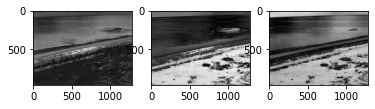

In [7]:
#Se aplica el filtro sobel a la imagen en sus tres canales. Se cambia el tipo de float para que sea compatible con la segmentacion en superpixeles mas adelante.
test2 = np.float32(sobel(testImg))
#Se muestran los tres canales de la imagen con filtro sobel. Se aprecia que el canal Saturation se distinguen mejor las manchas de sargazo.
showNImg([test2[:,:,0],test2[:,:,1],test2[:,:,2]])
#Guardar figura
plt.savefig('Figures/Sobel.png')

### Usando superpixeles

In [8]:
#Funcion para segmentar una imagen en superpixeles
#img - imagen a segmentar
#size - tamaño del superpixel
#compact - compacidad del superpixel
def imagetoSP(img,size,compact):
    # Crear el objeto de SLIC con las propiedades especificadas
    slic = cv2.ximgproc.createSuperpixelSLIC(img, algorithm = cv2.ximgproc.SLIC, region_size = size, ruler = compact)
    # Iterar el algoritmo
    slic.iterate()
    # Obtener la máscara de los ejes de los Super pixeles
    mask_slic = slic.getLabelContourMask()
    # Obtener un numpy array con los indices de los superpixeles
    label_slic = slic.getLabels()
    # Obtener el número de Super pixeles generados
    number_slic = slic.getNumberOfSuperpixels()
    # Negar la máscara de los superpixeles para poder haceer operaciones con esta
    mask_inv_slic = cv2.bitwise_not(mask_slic)  
    # Hacer la operación booleana de la máscara de Super Pixeles y la imagen original
    img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic)
    # RESULTADOS
    return img_slic, label_slic, number_slic

In [9]:
#Funcion para obtener los superpixeles que se encuentran dentro de la mascara de recorte
def nonZeroSPixels(labels,Spixels,Aimage,bias): #Entradas: indices de los superpixeles, numero de superpixeles, alpha de la imagen, umbral de aceptacion
    #Medir el tiempo de la operacion
    #tic = time.perf_counter()
    
    #Se crea una lista para los indices de los superpixeles
    pixels = []
    #Se ponen indices -1 a las zonas fuera de la mascara de recorte
    maskImg = np.where(Aimage>0,labels,-1) 
    #Para cada superpixel
    for i in Spixels: 
        #Si el superpixel no esta totalmente excluido
        if i in maskImg:
            #Obtenemos la proporcion de pixeles dentro de la mascara de recorte
            rel = np.sum(maskImg==i)/np.sum(labels==i)
            #Si la proporcion de pixeles dentro de la mascara de recorte es mayor a un umbral
            if rel>=bias: 
                #Guardar en la lista
                pixels.append(i)
            
    #Medir el tiempo de la operacion
    #toc = time.perf_counter()    
    #print(f"Se discrimino el superpixel en {toc - tic:0.4f} seconds")
    
    return pixels #Regresar indices de superpixeles aceptados

Como observamos que en el canal S de la imagen con filtro Sobel se apreciaba mejor el sargazo, lo utilizaremos para la segmentacion con superpíxeles.

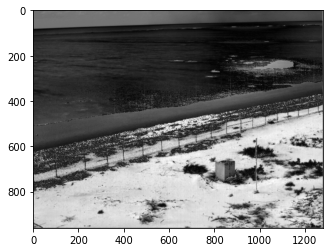

In [10]:
#Tomamos el canal S de la imagen con filtro sobel
sharpImg = test2[:,:,1]
#Vista previa del canal S
plt.imshow(sharpImg,cmap=cm.gray)
#Guardar figura
plt.savefig('Figures/Sobel_S.png')

Numero de superpixeles 1938


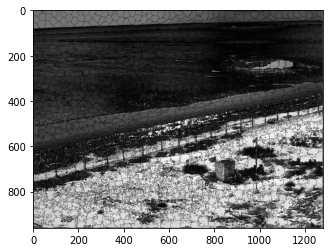

In [12]:
#Tamaño de superpixeles
sp_size = 25
#Compacidad de los superpixeles
sp_compact = 0.01
#Separamos la imagen en superpixeles
slicIm, lblSlic, n_Slic = imagetoSP(sharpImg,sp_size,sp_compact)
print("Numero de superpixeles",n_Slic)
#Vista previa de la imagen segmentada en superpixeles
plt.imshow(slicIm,cmap=cm.gray)
#Guardar figura
plt.savefig('Figures/SPixels_segments.png')
#color1 = label2rgb(lblSlic, image=segImg, bg_label=-1)

#### Discriminando zonas

Ya que la cámara parece estar todo el tiempo en el mismo lugar y que las zonas ocupan los mismos píxeles, podemos reducir las zonas de análisis.

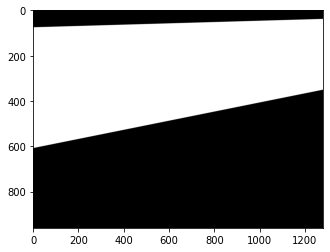

In [13]:
#Se abre la imagen con la mascara de referencia
base = Image.open("Mar_mask.png")
#La mascara se encuentra en el canal alpha, por lo que solo extraeremos esa parte
base = np.asarray(base.split()[-1])
#Vista previa de la mascara base
plt.imshow(base,cmap=cm.gray)
#Guardar figura
plt.savefig('Figures/Mar_zona.png')

In [15]:
#Se obtienen los superpixeles que se encuentran dentro de la mascara base
validPixels = nonZeroSPixels(lblSlic,range(n_Slic),base,0.5)
print("Superpixeles resultantes",len(validPixels))

Superpixeles resultantes 875


In [16]:
#Para visualizar mejor el resultado de quitar los superpixeles no validos (que no se encuentran dentro de la mascara)
maskedImg=np.zeros(sharpImg.shape)
for i in validPixels:
    ind = np.where(lblSlic==i)
    ind = list(map(tuple, np.array(ind).T))
    for x,y in ind:
        maskedImg[x,y]=slicIm[x,y]

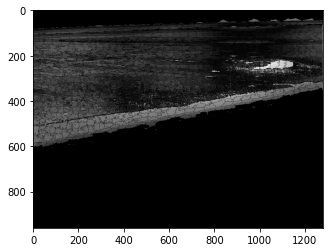

In [17]:
#Se muestran los superpixeles validos
plt.imshow(maskedImg,cmap=cm.gray)
#Guardar figura
plt.savefig('Figures/Valid_zone.png')

### GLCM con cualquier escala y un determinado numero de niveles

In [18]:
#image - imagen para analizar texturas
#indexes - indices de los pixeles dentro de la textura
#maxVal - nivel maximo de gris
#n - numero de niveles de gris
#offset - distancia al siguiente pixel
#angle - angulo al siguiente pixel (de 0 a 3.141592)
def GLCMmat(image,indexes,maxVal,n,offset,angle):
    #Creamos una matriz de ceros para inicializar la matriz GLCM
    M = np.zeros((n,n), dtype=np.uint8)
    #Obtenermos los pixeles que contienen la textura
    pixels=image[indexes]
    n_indexes = list(map(tuple, np.array(indexes).T))
    #Obtenemos los pasos hacia el siguiente pixel
    dx = np.int8(offset * np.cos(angle))
    dy = np.int8(offset * np.sin(angle))
    #Para cada nivel de gris
    for a in range(n):
        #Buscamos los indices de los pixeles que corresponden a ese nivel (inclusivo el 0 y el valor maximo)
        if(a==0):
            current_indexes = np.where(np.logical_and(pixels>=maxVal * a / n, pixels<=maxVal * (a+1) / n))
        else:
            current_indexes = np.where(np.logical_and(pixels>(maxVal/n * a), pixels<=(maxVal/n * (a+1))))
            
        #Si no hay pixeles dentro de ese nivel, pasar al siguiente
        if(len(current_indexes[0])==0):
            continue
        #Los transformamos de una tupla de listas a una lista de tuplas para iterarlos
        current_indexes = list(map(tuple, np.array(current_indexes).T))
        #Por cada pixel de ese nivel de gris
        for v_i, in current_indexes:
            #print(v_i)
            x,y=n_indexes[v_i]
            #Si el siguiente pixel se encuentra dentro de los limites de la imagen
            if(x+dx>=0 and x+dx<image.shape[0] and y+dy>=0 and y+dy<image.shape[1]):
                #Para el nivel de gris del siguiente pixel
                for b in range(n):
                    #Si el siguiente pixel de la imagen se encuentra en el nivel de gris
                    if(image[x+dx,y+dy]>=(maxVal/n * b) and image[x+dx,y+dy]<=(maxVal/n * (b+1))):
                        #Sumar el conteo de la matriz GLCM y terminar el ciclo for (pasar al siguiente pixel)
                        M[a,b]+=1
                        break
    #La salida es la matriz GLCM simetrica
    return M+M.T

In [19]:
#Funcion para obtener alguna propiedad GLCM
def computeFeatures(GLCM):
    GLCM = GLCM/np.sum(GLCM)
    scale_gray = GLCM.shape[0]
    # Medidas a obtener relacionadas al contraste
    # con_m --- Contrast, sum of squares variance or inertia
    # dis_m --- Dissimilarity
    # idm_m --- Homogeneity or Inverse Difference Moment
    con_m, dis_m, idm_m = 0, 0, 0
    # Medidas a obtener relacionadas al orden
    # asm_m --- Angular Second Moment
    # ene_m --- Energy
    # ent_m --- Entropy    
    asm_m, ene_m, ent_m = 0, 0, 0    
    # Medidas a obtener relacionadas a la estadística descriptiva
    # mhu_m -- GLCM Mean i & j are equal for symmetrical GLCM
    # var_m -- GLCM Variance i & j are equal for symmetrical GLCM
    # cor_m -- Correlation
    mhu_m, var_m, cor_m = 0, 0, 0    
    # Recorrer la matriz GLCM para obtener medidas de contraste y orden
    for i in range(scale_gray):
        for j in range(scale_gray):
            con_m += GLCM[i,j] * ((i-j)**2)
            dis_m += GLCM[i,j] * abs(i-j)
            idm_m += GLCM[i,j] / (1 + ((i-j)**2))
            asm_m += GLCM[i,j]**2
            if GLCM[i,j] > 0:
                ent_m += GLCM[i,j] * (-np.log(GLCM[i,j]))
            mhu_m += GLCM[i,j] * i
    ene_m = asm_m **(1/2)
#     # Recorrer la matriz GLCM por segunda vez para obtener medidas de estadística descriptiva
#     for i in range(scale_gray + 1):
#         for j in range(scale_gray + 1):
#             var_m += GLCM[i,j] * (i - mhu_m)**2
#     # Recorrer la matriz GLCM por tercera vez para obtener medidas de estadística descriptiva
#     for i in range(scale_gray + 1):
#         for j in range(scale_gray + 1):
#             cor_m += GLCM[i,j] * (((i-mhu_m)*(j-mhu_m))/(var_m))       

#     print(f"Medidas obtenidas--------")
#     print(f"Contraste      = {con_m}")
#     print(f"Disimilitud    = {dis_m}")
#     print(f"Homogeneidad   = {idm_m}")
#     print(f"ASM            = {asm_m}")
#     print(f"Energia        = {ene_m}")
#     print(f"Entropía       = {ent_m}\n")
#     print(f"Promedio i o j = {mhu_m}")
#     print(f"Varianza i o j = {var_m}")
#     print(f"Correlación    = {cor_m}")
    return [con_m, dis_m, idm_m, ene_m, ent_m]

In [20]:
#Se muestra la cantidad de superpixeles restantes
print(len(validPixels))
#Para los primeros superpixeles
for i in validPixels[:5]:
    #En los pixeles que corresponden a ese superpixel
    pixels = np.where(lblSlic==(i))
    #Se obtiene la matriz GLCM del superpixel
    glcm = GLCMmat(sharpImg,pixels,1.0,10,1.5,3.141592/3)
    #Se muestran los valores de contraste, disimulitud, homogeneidad, energia y entropia
    print(computeFeatures(glcm))
    

875
[0.0392156862745098, 0.0392156862745098, 0.9803921568627452, 0.7970775146736411, 0.6651364439578314]
[0.01694915254237288, 0.01694915254237288, 0.9915254237288135, 0.8246071901810264, 0.5626060151924168]
[0.11392405063291139, 0.11392405063291139, 0.9430379746835444, 0.8395087109858852, 0.6880335335089048]
[0.15384615384615385, 0.15384615384615385, 0.9230769230769229, 0.7438107540697583, 0.9464340885014036]
[0.11538461538461538, 0.11538461538461538, 0.9423076923076923, 0.77894507127468, 0.8815095081481519]


## Entrenamiento
Se tienen mascaras de recorte, donde se ubicaron manualmente las regiones que contienen el sargazo. Éstas se aplicaran a su respectiva imagen sin recorte, aplicando los filtros de los procedimientos anteriores, y analizando sus caracteristicas de GLCM
- Se leen las mascaras de entrenamiento con su respectiva imagen de color (en HSV)
- Se aplica el filtro Unsharp Masking a las imagenes de color
- Se aplica el filtro Sobel a la imagen resultante del paso anterior, y se guarda el canal S
- Se divide la imagen en superpixeles
- Se rechazan los superpixeles que no estan dentro de la mascara base
- Se analizan las texturas de los superpixeles restantes
 - Utilizando la mascara de recorte de entrenamiento correspondiente, la etiqueta será "sargazo" si hay una proporcion mayor de píxeles del superpíxel dentro de la máscara de entrenamiento, de otra forma será "agua"
 - El análisis GLCM se hará obteniendo las propiedades contraste, disimulitud, homogeneidad, energia y entropia, para sus matrices en los canales Hue y Saturation, con y sin filtro Sobel (4 canales, 20 elementos en total)

In [21]:
def PreProcesamiento(img,size,compact):
    #Unsharp Masking
    um_Img = unsharp_mask(img,radius=3,amount=0.1,multichannel=False)
    #Filtro Sobel
    sobel_Img = np.float32(sobel(um_Img))
    #Canal S como referencia para superpixeles (en float32 para poder usar la funcion)
    sharp_Img = sobel_Img[:,:,1]
    #Separamos la imagen en superpixeles (tamaño 40, compacidad 0.05)
    slicIm, lblSlic, n_Slic = imagetoSP(sharp_Img,size,compact)
    
    return um_Img, sobel_Img, sharp_Img, slicIm, lblSlic, n_Slic

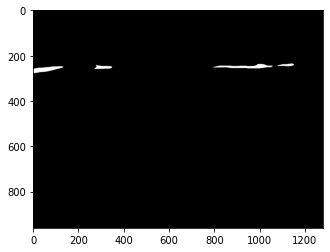

In [22]:
#Se leen las mascaras de entrenamiento con su imagen correspondiente
mask = ReadAlpha("Training/","Train",23,".png")
training = ReadImg('Training/','Color',range(1,24),'.png')
#Vista previa de alguna de las mascaras
plt.imshow(mask[0], cmap=cm.gray)

In [23]:
M = np.array([]) #Se crea un arreglo vacio que sera la matriz de entrenamiento

#Offset del analisis de texturas
p_distance = 2
#Angulo del analisis de texturas
p_angle = 3.141592/6
#Numero de escalas de grises
scale_gray = 16
#Tamaño de superpixeles
sp_size = 25
#Compacidad de los superpixeles
sp_compact = 0.05

#Para cada mascara segun su indice
for i in tqdm(range(len(mask))[:]):
    
    #Separamos la imagen en superpixeles (tamaño 40, compacidad 0.05)
    um_Img, sobel_Img, sharpImg, slicIm, lblSlic, n_Slic = PreProcesamiento(training[i],sp_size,sp_compact)
    
    #Se obtienen los superpixeles que se encuentran dentro de la mascara base
    validPixels = nonZeroSPixels(lblSlic,range(n_Slic),base,0.5)
    #Se obtienen los superpixeles dentro de la mascara de entrenamiento (si los superpixeles de entrenamiento son pocos, intentar bajar el umbral)
    trainPixels = nonZeroSPixels(lblSlic,validPixels,mask[i],0.5)
    #print(len(trainPixels))
    #Guardamos en una lista las imagenes para extraer caracteristicas (canal H y S, con y sin Sobel)
    t_imgs = [um_Img[:,:,0],um_Img[:,:,1],um_Img[:,:,2],sobel_Img[:,:,0],sobel_Img[:,:,1],sobel_Img[:,:,2]]
    
    #Para cada superpixel de entrenamiento
    for SP in trainPixels:
        #Se crea un arreglo vacio que sera el vector de caracteristicas
        v = np.array([])
        for c_img in t_imgs:
            #En los pixeles que corresponden a ese superpixel
            pixels = np.where(lblSlic==SP)
            #Se obtiene la matriz GLCM del superpixel
            glcm = GLCMmat(c_img,pixels,1.0,scale_gray,p_distance,p_angle)
            #Se muestran los valores de contraste, disimulitud, homogeneidad, energia y entropia
            c_v = np.array(computeFeatures(glcm))
            
            #Se crea un vector con 20 caracteristicas (se van concatenando las 5 propiedades de textura para las 4 imagenes)
            if len(v)>0:
                v = np.concatenate((v,c_v),axis=None)
            else:
                v = c_v
                
        #Se concatena al final la salida, siendo 1 si el superpixel corresponde al sargazo.
        v = np.concatenate((v,1),axis=None)
        
        if not np.isnan(v).any():
            if len(M)>0:
                M = np.vstack((M,v))
            else:
                M = v
        
    #Se obtienen los superpixeles fuera de la mascara de entrenamiento
    trainPixels_0 = []
    #Tomar superpixeles de la region que no es sargazo en cierta proporcion
    while(len(trainPixels_0)<len(trainPixels)*2):
        choice = np.random.choice(validPixels)
        if choice not in trainPixels:
            trainPixels_0.append(choice)
            
    #Para cada superpixel de entrenamiento (con etiqueta 0)
    for SP in trainPixels_0:
        #Se crea un arreglo vacio que sera el vector de caracteristicas
        v = np.array([])
        for c_img in t_imgs:
            #En los pixeles que corresponden a ese superpixel
            pixels = np.where(lblSlic==SP)
            #Se obtiene la matriz GLCM del superpixel
            glcm = GLCMmat(c_img,pixels,1.0,scale_gray,p_distance,p_angle)
            #Se muestran los valores de contraste, disimulitud, homogeneidad, energia y entropia
            c_v = np.array(computeFeatures(glcm))
            
            #Se crea un vector con 20 caracteristicas (se van concatenando las 5 propiedades de textura para las 4 imagenes)
            if len(v)>0:
                v = np.concatenate((v,c_v),axis=None)
            else:
                v = c_v
                
        #Se concatena al final la salida, siendo 1 si el superpixel corresponde al sargazo.
        v = np.concatenate((v,0),axis=None)
        
        #Se apilan verticalmente los vectores de caracteristicas
        if not np.isnan(v).any():
            if len(M)>0:
                M = np.vstack((M,v))
            else:
                M = v

  0%|          | 0/23 [00:00<?, ?it/s]

<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)


In [26]:
#Dimensiones de la matriz de entrenamiento
print(M.shape)

(1066, 31)


In [27]:
#Mezclar aleatoriamente los vectores de entrenamiento
np.random.shuffle(M)
print(M.shape)

N_test = int(M.shape[0]/4) #Numero de vectores de prueba

X,Y = M[:,:30],M[:,30]

#Tomar los ultimos N-test valores para pruebas
X_test, Y_test = X[-N_test:,:] , Y[-N_test:]
#Tomar el resto para entrenamiento
X_train, Y_train = X[:-N_test,:], Y[:-N_test]

(1066, 31)


#### Componentes principales (Intento)

In [28]:
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)
# Sanity check on dimensions
print("X:", X.shape)
print("U:", U.shape)
print("Sigma:", Sigma.shape)
print("V^T:", VT.shape)

X: (1066, 30)
U: (1066, 30)
Sigma: (30,)
V^T: (30, 30)


In [29]:
#sorted_i = np.argsort(-1*mi)
print(Sigma)

[6.58632683e+02 1.31076295e+02 4.63807994e+01 3.39343596e+01
 2.48995842e+01 1.73589075e+01 1.62318386e+01 1.34073601e+01
 1.25015217e+01 9.89505764e+00 6.30730370e+00 5.64189318e+00
 5.07090750e+00 4.89141042e+00 3.23972640e+00 2.94118434e+00
 2.29900024e+00 1.99570539e+00 1.64338866e+00 1.10370132e+00
 8.29641440e-01 7.89566887e-01 7.05084121e-01 6.73455085e-01
 5.82477794e-01 1.12441187e-01 1.01118386e-01 3.54085206e-02
 1.08857448e-02 4.29118299e-03]


In [30]:
num_components = 10 # Number of principal components
M_PCA = VT[:num_components,:].T
X_PCA = X @ M_PCA
print(X_PCA.shape)

(1066, 10)


In [31]:
#Tomar los ultimos N-test valores para pruebas
X_test = X_PCA[-N_test:,:]
#Tomar el resto para entrenamiento
X_train = X_PCA[:-N_test,:]

### Clasificación con KNN


------------------------------------
Entrenamiento KNN

GLCM -> Distancia = 2 Ángulo= 0.5235986666666667° Escala de gris = 16



  0%|          | 0/39 [00:00<?, ?it/s]

El mejor valor fue K = 7
Presición en los datos de prueba   = 0.90977
Error medio en los datos de prueba = 0.09023


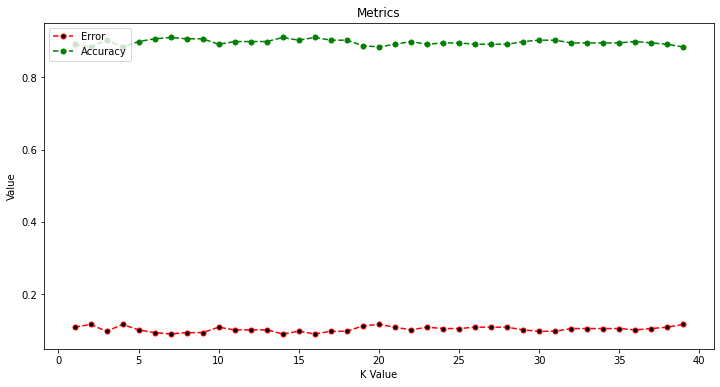

In [32]:
print(f'\n------------------------------------')
print(f'Entrenamiento KNN\n')
# Mostrar información del dataset
print(f"GLCM -> Distancia = {p_distance} Ángulo= {p_angle}° Escala de gris = {scale_gray}\n")
# Lista para guardar la precisión y el error de los parámetros n_neighbors
scores = []
errors = []
score_best = 0
error_best = 30000000000000
# Rango del parámetro n_neighbors
k_range = range(1, 40)

# Calcular el erro para los valores de K entre 1 y 40
for k in tqdm(k_range):
    # Crear el modelo con el parámetro K variable
    knn = KNeighborsClassifier(n_neighbors=k)
    # Entrenar el modelo con los datos de entrenamiento
    knn.fit(X_train, Y_train)
    # Obtener el desempeño del modelo con los datos de entrenamiento
    score=knn.score(X_test, Y_test)
    scores.append(score)
    # Obtener las clases de los datos de prueba
    Y_pred = knn.predict(X_test)
    # Carcular el error promedio del modelo clasificador
    error = np.mean(Y_pred != Y_test)
    errors.append(error)
    
    #Guardar al mejor modelo
    if score > score_best and error < error_best :
        k_best = k
        knn_best = knn
        score_best, error_best = score, error

# Mostrar los resultados de los distintos valores de K
plt.figure(figsize=(12, 6))
plt.plot(k_range, errors, color='red', linestyle='dashed', marker='o',
         markerfacecolor='black', markersize=5, label="Error")
plt.plot(k_range, scores, color='green', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=5, label="Accuracy")
plt.legend(loc="upper left")
plt.title('Metrics')
plt.xlabel('K Value')
plt.ylabel('Value')

#Guardar figura
plt.savefig('Figures/KNN_e.png')

# Mostrar al mejor
print(f'El mejor valor fue K = {k_best}')
print(f'Presición en los datos de prueba   = {scores[k_range.index(k_best)]:.5f}')
print(f'Error medio en los datos de prueba = {errors[k_range.index(k_best)]:.5f}')

In [33]:
# Obtener el reporte del mejor modelo de KNN

# Obtener las clases de los datos de prueba
Y_pred = knn_best.predict(X_test)
# Calcular el reporte de precisión
print(classification_report(Y_test,Y_pred))

#Calcular la matriz de confusión
print(confusion_matrix(Y_test, Y_pred))

print("\n==================================================")
print(f"Entrenamiento finalizado")

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       172
         1.0       0.83      0.94      0.88        94

    accuracy                           0.91       266
   macro avg       0.90      0.92      0.90       266
weighted avg       0.92      0.91      0.91       266

[[154  18]
 [  6  88]]

Entrenamiento finalizado


#### Clasificación de superpíxeles con KNN
A las imágenes a analizar se les aplica el mismo preprocesamiento, como con las imágenes de entrenamiento. Después se subdivide en superpíxeles; se toman los que corresponden a la zona de análisis, y cada uno se clasifica con el modelo KNN ya entrenado.

In [34]:
#Abrir todas las imagenes en una carpeta
imges1 = list() #Se crea una lista vacia para contener las imagenes
for name in listdir("Images1"): #Para cada imagen enumerada desde el 1
    filePath= "Images1/"+name
    try:
        imges1.append(Image.open(filePath).convert("HSV")) #Se intenta agregar la imagen en formato HSV
    except:
        print("No se logro agregar la imagen",filePath) #Si hay algun error, se da un aviso

In [38]:
#Imagenes a clasificar
Listof_Test_Images = imges

#Lista de frames para un GIF
frames = []

#Diccionario para guardar los indices de las clases.
classes_dict={-1:list(),0:list(),1:list()}

for img in tqdm(Listof_Test_Images):
    frames.append(img.convert("P"))
    #Pasar la imagen a arreglo 
    img = np.array(img)
    #Separamos la imagen en superpixeles (tamaño 40, compacidad 0.05)
    um_Img, sobel_Img, sharpImg,slicIm, lblSlic, n_Slic = PreProcesamiento(img,sp_size,sp_compact)
    #Se obtienen los superpixeles que se encuentran dentro de la mascara base
    validPixels = nonZeroSPixels(lblSlic,range(n_Slic),base,0.5)
    #Guardamos en una lista las imagenes para extraer caracteristicas (canal H y S, con y sin Sobel)
    t_imgs = [um_Img[:,:,0],um_Img[:,:,1],um_Img[:,:,2],sobel_Img[:,:,0],sobel_Img[:,:,1],sobel_Img[:,:,2]]
    
    #Para cada superpixel dentro de la mascara base
    for SP in tqdm(validPixels):
        #Se crea un arreglo vacio que sera el vector de caracteristicas
        x = np.array([])
        for c_img in t_imgs:
            #En los pixeles que corresponden a ese superpixel
            pixels = np.where(lblSlic==SP)
            #Se obtiene la matriz GLCM del superpixel
            glcm = GLCMmat(c_img,pixels,1.0,scale_gray,p_distance,p_angle)
            #Se muestran los valores de contraste, disimulitud, homogeneidad, energia y entropia
            c_x = np.array(computeFeatures(glcm))
            
            #Se crea un vector con 20 caracteristicas (se van concatenando las 5 propiedades de textura para las 4 imagenes)
            if len(x)>0:
                x = np.concatenate((x,c_x),axis=None)
            else:
                x = c_x
                
        #Se imprime la clase que se predijo para ese valor (la condicion isnan es para evitar vectores con valores Not a Number)
        if not np.isnan(x).any():
            x_PCA = x @ M_PCA
            classes_dict[int(knn_best.predict([x_PCA]))].append(SP)
            #print("SP=",SP,"Clase",knn_best.predict([x]))
        else:
            classes_dict[-1].append(SP)
            #print("SP=",SP,"Clase",-1)
            
    #Matriz que guardara las etiquetas de los pixeles clasificados
    lbl_final = -1*np.ones(img[:,:,0].shape)

    #Para cada clase con su lista de SP que le corresponden
    for key, value in classes_dict.items():
        #Para cada superpixel
        for SP in value:
            #Colocar las clases que corresponden a ese superpixel
            lbl_final[np.where(lblSlic==SP)]=key
    
    #Contar los pixeles con sargazo
    print("Numero de pixeles con sargazo = ", np.sum(lbl_final==1))

    #Superponer la matriz con las etiquetas en la imagen original
    color = label2rgb(lbl_final, image=img, bg_label=-1)

    #Mostrar la imagen resultante
    frames.append(Image.fromarray((color*255).astype(np.uint8)).convert("P"))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/847 [00:00<?, ?it/s]

<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)


Numero de pixeles con sargazo =  64652


  0%|          | 0/858 [00:00<?, ?it/s]

<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)


Numero de pixeles con sargazo =  121219


  0%|          | 0/850 [00:00<?, ?it/s]

<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)
<ipython-input-19-731ef0ff6d47>:3: RuntimeWarning: invalid value encountered in true_divide
  GLCM = GLCM/np.sum(GLCM)


Numero de pixeles con sargazo =  180750


In [39]:
#Guardar los frames en un gif
frames[0].save('res.gif',
               save_all=True, append_images=frames[1:], optimize=False, duration=500, loop=0)